If we increase the context size (from 1 character to 2, for example), the model we built is going to get overly complicated. \
\
This notebook focuses on implementing a multi-layer perceptron character-level language model. \
\
**Number of features = number of dimensions** \
\
Randomly initialized vectors of words (or characters in this notebook) => tune the embeddings (vectors) using backpropagation.

In [253]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [254]:
words = open('names.txt', 'r').read().splitlines()

In [255]:
len(words)

32033

In [256]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [257]:
def build_dataset(words):
    block_size = 3 
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [258]:
X, Y = build_dataset(words[:5])

torch.Size([32, 3]) torch.Size([32])


In [259]:
X.shape, X.dtype, Y.shape, Y.dtype # the dataset we built has 32 examples with 3 integers each and 32 integer labels 

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [260]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [261]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [262]:
# we have 27 characters to embed in a lower-dimensional space
# in the paper (Bengio et al.), they embed 17000 words into 30d space
# we can embed 27 characters in 2d
C = torch.randn((27, 2))

In [263]:
C[[5, 6, 7]] # the vectors of E, F, G in the embedding space

tensor([[ 0.3010,  0.2846],
        [-0.6554, -0.4376],
        [-1.4828,  0.8736]])

In [264]:
# we can embed all of the integers like:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

### The hidden layer

In [265]:
W1 = torch.randn((6, 100)) # weights of the hidden layer: we have three 2D embeddings, so the number of inputs = 6
b1 = torch.randn(100) # number of neurons in the layer is variable, e.g. 100

emb @ W1 + b1 matrix multiplication does not work because the dimensions don't match, so we need to concatenate the input layer, or more efficiently, "view" it in another dimension (constant space complexity).

**(32, 3, 2) => (32, 6)**

In [266]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # tanh activation layer, we'll have numbers between -1 and 1

In [267]:
h.shape

torch.Size([32, 100])

### The output layer

In [268]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [269]:
logits = h @ W2 + b2

In [270]:
logits.shape

torch.Size([32, 27])

In [271]:
counts = logits.exp()

In [272]:
prob = counts / counts.sum(1, keepdims=True)

In [273]:
prob.shape

torch.Size([32, 27])

In [274]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(19.5020)

### Summary
Shorter version of the code + we replace the following lines: \
```python
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
```
with
```python
F.cross_entropy(logits, Y)
```
**Why F.cross_entropy is better than manual implementation:**
1. Uses optimized, fused kernels that avoid creating intermediate tensors (```counts``` and ```prob```) => reduces memory overhead and improves forward and backward passes.
2. Manual approach can overflow when exponentiating large logits. F.cross_entropy internally subtracts the maximum logit value before exponentiation => prevents overflow, maintains mathematical equivalence, achieves numerical stability.

In [275]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [276]:
g = torch.Generator().manual_seed(76829343259483)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [277]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [278]:
for p in parameters:
    p.requires_grad = True

In [279]:
for _ in range(10):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

6.352474689483643


### Training the whole dataset
There are too many parameters, so it's gonna take a while. We want to select a random portion of the dataset (mini-batch), forward-backward-update on that mini-batch, and keep iterating.

In [280]:
X, Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [281]:
g = torch.Generator().manual_seed(76829343259483)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [282]:
for p in parameters:
    p.requires_grad = True

**How to determine the best learning rate** \
Step linearly between the exponents of the learning rate (between 0.001 and 1), and see which one has the lowest loss.

In [283]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [284]:
lri = []
lossi = []

for i in range(1000):
    
    # mini-batch construct
    idx = torch.randint(0, X.shape[0], (32,)) # 32 random indices between 0 and 228146

    # forward pass
    emb = C[X[idx]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[idx])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

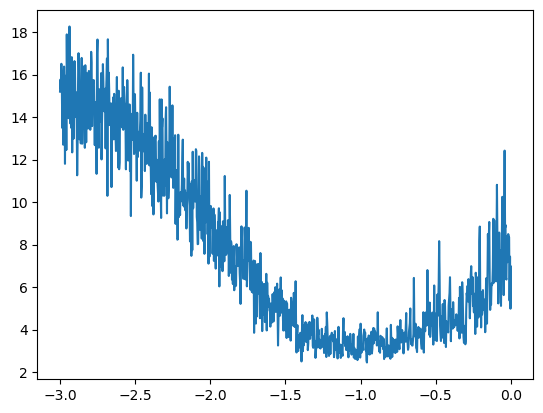

In [285]:
plt.plot(lri, lossi)

Based on the graph above, we can see that a good learning rate is somewhere around 0.1 (exponent of -1.0). \
Now let's reset the parameters one last time and run the training:

In [286]:
g = torch.Generator().manual_seed(76829343259483)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [287]:
for p in parameters:
    p.requires_grad = True

In [288]:
for i in range(10000):
    idx = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[idx]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[idx])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

In [289]:
# loss of the whole dataset (not just the mini-batch)
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4562, grad_fn=<NllLossBackward0>)

After training the model with a learning rate of 0.1 multiple times, we perform a learning rate decay (use a lower learning rate, e.g. 0.01). \
Achieved a loss of 2.31, better than the previous bigram model. \

### Train/Validation/Test split
We need to split the data into three groups to avoid overfitting on the training data:

- Training split (~80%) - optimize the parameters of the model
- Dev/validation split (~10%) - optimize the hyperparameters (e.g. the size of the embedding, hidden layer, regularization strength)
- Test split (~10%) - evaluate the performance of the model

In [290]:
import random
random.seed(42)
random.shuffle(words)
n1, n2 = int(0.8*len(words)), int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [291]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [292]:
g = torch.Generator().manual_seed(76829343259483)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [293]:
for p in parameters:
    p.requires_grad = True

In [294]:
for _ in range(110000):
    
    idx = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[idx]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[idx])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [295]:
# evaluate the loss with the training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3127, grad_fn=<NllLossBackward0>)

In [296]:
# evaluate the loss with the validation set
emb = C[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.3141, grad_fn=<NllLossBackward0>)

I got 2.26 on training and 2.27 on validation set (after lr=0.1 on 100000 iterations and lr=0.01 on 10000 iterations). \
In this case, it's not overfitting and the neural net is also very small to memorize data. \
Then, I increased the hidden layer size from 100 to 300 and trained a bit more. Reduced the learning rate. Achieved a loss of 2.24 on training and 2.5 on validation set. \
Now let's visualize the embedding:

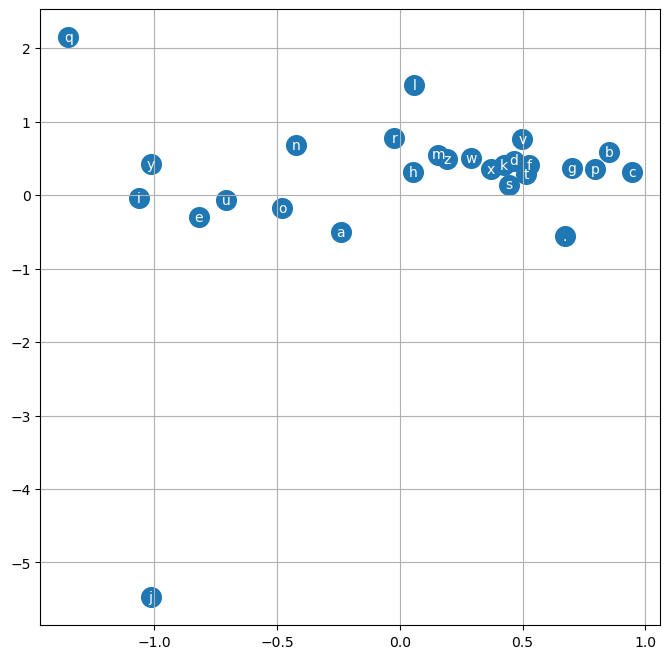

In [297]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

The embeddings make sense:
- Vowels are clustered together <- the neural net treats them similarly.
- What's up with j lol.
- q is a special character.

The loss didn't change much after increasing the hidden layer size, so maybe the problem is with the embedding space. I increased the dimension from 2 to 10 (so the hidden layer will take 30 inputs).

After training the model 100000 times with a learning rate of 0.1 (and hidden layer size of 200), and then performing a learning rate decay and training 10000 times with a learning rate of 0.1, I achieved 2.13 on training and 2.16 on validation set. We're slowly starting to overfit.

### Sampling from the model

In [298]:
g = torch.Generator().manual_seed(6789013249857)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break

    print(''.join(itos[i] for i in out))

nara.
direnellere.
gawycherysso.
par.
mylynn.
dasol.
nosse.
gawirone.
zykia.
ashiesmesy.
krairae.
mama.
toszi.
zaya.
bren.
kalyn.
aspo.
shekha.
ailea.
hazesl.
